In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
# from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [4]:
from hardware.daq.sidig import FIFO_DataAcquisition
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

SIDIG_ADDRESS = "dev/spcm0"
SIDIG_maxsr = 500e6  # Hz
SIDIG_timebase = int(1 / SIDIG_maxsr * 1e9)  # ns
dig=FIFO_DataAcquisition(
                sn_address=SIDIG_ADDRESS
            )

In [5]:
freq = 16.6
freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.6 GHz
Actual Output CW Freqeuncy :16.600000005215406 GHz


In [6]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [7]:
dur_pt = 16E6 # duration of each frequency point
dig_trig_len=20
divpart_pt = 2
clock_rate = 500E-6 #GHz
daqtrig_delay = 1/clock_rate #delay
seq_daqtrig = [(dur_pt/2.0, HIGH), (dur_pt/2.0, LOW)]
seq_laser = [(dur_pt, HIGH)]
seq_mwA = [(dur_pt/2.0/divpart_pt, HIGH), (dur_pt/2.0/divpart_pt, LOW)]*divpart_pt
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*int(dur_pt*clock_rate)
# seq_dig= [(dur_pt/2.0/divpart_pt, LOW), (dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW),(dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW)]*divpart_pt
seq_dig= [(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW),(dig_trig_len,LOW),(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW)]*divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital('sdtrig',seq_dig)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
# pg.setDigital("dtrig", seq_daqtrig)
# pg.setDigital("dclk", seq_clock)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [8]:
dig_trig_len = 20
divpart_pt = 2

mw_dur = 16e6//4

seq_laser = [(mw_dur, HIGH)]
seq_mwA = [
    (mw_dur, HIGH),
    (mw_dur, LOW),
] * divpart_pt

seq_dig = [
    (dig_trig_len, HIGH),
    (mw_dur - dig_trig_len, LOW),
    (dig_trig_len, LOW),
    (dig_trig_len, HIGH),
    (mw_dur - dig_trig_len, LOW),
] * divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital("sdtrig", seq_dig)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [8]:
def seqtime_tb(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])
def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

In [9]:
## set up the data aquication with the digitizer 
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
mw_len=dur_pt/2.0/divpart_pt
t_seq = seqtime_cb(seq_laser)
rate_refresh = 1 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size= 256 #int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
# posttrig_size=int((t_ribloc+t_ribloc_isc)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc
posttrig_size=int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc

segment_size = pretrig_size+posttrig_size 
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [11]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=8,
             pretrig_size=16,
             posttrig_size=1048576//4-16,
             segment_size=1048576//4,
             terminate_input=TERMIN_INPUT_1MOHM,
             DCCOUPLE = 0,
             sampling_rate=hcf.SIDIG_maxsr
            #  terminate_input=TERMIN_INPUT_50OHM,
             ))


In [12]:
pretrig_size=128
posttrig_size=1024*1000-pretrig_size
freq_start = 16.45-0.25
freq_stop = 16.45+0.25
B = 14.103
f_e = 28.0249514242*B
f_NVp1 = f_e + 2.8705
f_NVm1 = f_e - 2.8705
# f_NVguess = 392.8397714495659
f_NVguess = 398.5567714869976
freq_start = (f_NVguess-0.030)/24.0
freq_stop = (f_NVguess+0.030)/24.0
# check the minium step size
freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
step_min = freqminstep_list[0] # in Hz
freq_step = 0.5E-3/24.0
freq_step = int(freq_step/step_min*1E9)*step_min/1E9

freq_array = np.arange(freq_start, freq_stop, freq_step)
freq_array=freq_array
# print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
freq_actual = np.zeros(len(freq_array))

# Allocate arrays
signal = np.zeros((len(freq_actual), pretrig_size + posttrig_size))
background = np.zeros((len(freq_actual), pretrig_size + posttrig_size))

# Repeat measurement
num_repeat = 1
signal_av = np.zeros(len(freq_actual))
background_av = np.zeros(len(freq_actual))
segment_list = np.zeros(len(freq_actual))

laser.laser_on() # turn off laser

for mmm in range(num_repeat):
    for jj, ff in enumerate(freq_array):
        # print(f"Frequency: {ff} GHz")
        run_time = .1
        segments = 0
        
        dig.assign_param(dict(
            readout_ch=readout_ch,
            amp_input=amp_input,
            num_segment=8,
            pretrig_size=pretrig_size,
            posttrig_size=posttrig_size,
            segment_size=pretrig_size+posttrig_size,
            terminate_input=TERMIN_INPUT_1MOHM,
            DCCOUPLE=0,
            sampling_rate=hcf.SIDIG_maxsr 
        ))
        dig.set_config()
        errorbyte, freq_actual[jj] = mwsyn.cw_frequency(ff)
        pg.stream(n_runs=INF)  # Example function for pulse generator (replace with actual implementation)
        dig.start_buffer()
        pg.startNow()

        start_time = time.monotonic()
        while time.monotonic() - start_time < run_time:
            rawraw = dig.stream()
            assert rawraw.shape[0] % 2 == 0
            assert rawraw.shape[0] != 0

            rawraw_on = rawraw[0::2, :, :]
            rawraw_off = rawraw[1::2, :, :]
            segments += np.shape(rawraw)[0] // 2
            # print("hello")
            # signal[jj, :] += rawraw_on.reshape(-1, rawraw_on.shape[-1]).sum(axis=0)
            # background[jj, :] += rawraw_off.reshape(-1, rawraw_off.shape[-1]).sum(axis=0)
            # print(f"rawraw_on.shape[0]: {rawraw_on.shape[0]}")
            for ii in range(0,rawraw.shape[0] // 2):
                # print(f"Processing segment {ii} for freq index {jj}")
                signal[jj,:] += np.ravel(rawraw_on[ii])
                background[jj,:] += np.ravel(rawraw_off[ii])

        dig.stop_card()
        pg.forceFinal()
        # pg.reset()
        segment_list[jj] += segments


SETTINGS: card timeout =  5 s
SETTINGS: # of segments =  1024000 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  128 Sa
SETTINGS: termination =  0
notify size:  2048000.0 Sa
Card stopped
SETTINGS: card timeout =  5 s
SETTINGS: # of segments =  1024000 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  128 Sa
SETTINGS: termination =  0
notify size:  2048000.0 Sa
Card stopped
SETTINGS: card timeout =  5 s
SETTINGS: # of segments =  1024000 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  128 Sa
SETTINGS: termination =  0
notify size:  2048000.0 Sa
Card stopped
SETTINGS: card timeout =  5 s
SETTINGS: # of segments =  1024000 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  128 Sa
SETTINGS: termination =  0
notify size:  2048000.0 Sa
Card stopped
SETTINGS: card timeout =  5 s
SETTINGS: # of segments =  1024000 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  128 Sa
SETTINGS: termination =  0
notify size:  2048000.0 S

In [13]:
segment_list

array([10., 11., 11., 12., 10., 11., 11., 11., 12., 11., 12., 11., 11.,
       11., 10., 11., 11., 11., 10., 11., 10., 10., 10., 11., 10., 11.,
       11., 11., 11., 11., 10., 11.,  9., 10., 11., 12., 11., 11., 10.,
       11., 11., 11., 10., 12., 10., 11., 10., 10., 11., 11., 11., 11.,
       11., 11., 10., 11., 12., 10., 11., 11., 11., 11., 11., 11., 11.,
       12., 11., 11., 11., 11., 10., 11., 10., 11., 11., 11., 10., 10.,
       11., 11., 12., 11., 11., 11., 11., 11., 11., 12., 10., 12., 10.,
       11., 10., 10., 10., 11., 12., 10., 10., 10., 11., 11., 11., 10.,
       10., 11., 10., 11., 11., 11.,  9., 10., 10., 11., 11., 11., 10.,
       10., 11., 10., 11.])

In [14]:
import matplotlib.pyplot as plt

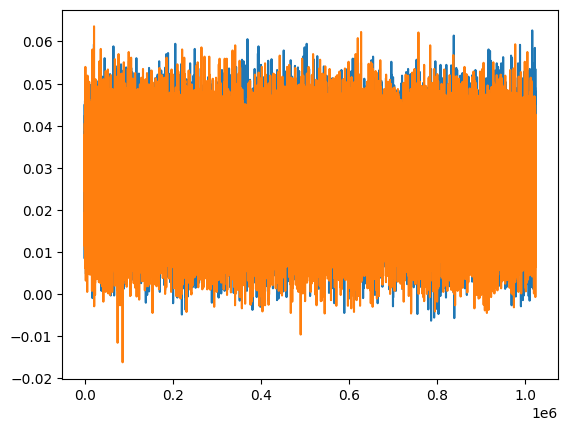

In [15]:
plt.plot(np.ravel(rawraw_on))
plt.plot(np.ravel(rawraw_off))

In [16]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
pg.reboot()

# close all NI tasks

task_uca.stop()
task_uca.close()

# reboot(optional) and close the MW synthesizer 
mwsyn.reboot()
mwsyn.close()

MW Synthesizer Rebooted!


In [17]:
np.shape(signal)

(121, 1024000)

In [18]:
np.shape(signal)

(121, 1024000)

In [19]:
segment_list

array([10., 11., 11., 12., 10., 11., 11., 11., 12., 11., 12., 11., 11.,
       11., 10., 11., 11., 11., 10., 11., 10., 10., 10., 11., 10., 11.,
       11., 11., 11., 11., 10., 11.,  9., 10., 11., 12., 11., 11., 10.,
       11., 11., 11., 10., 12., 10., 11., 10., 10., 11., 11., 11., 11.,
       11., 11., 10., 11., 12., 10., 11., 11., 11., 11., 11., 11., 11.,
       12., 11., 11., 11., 11., 10., 11., 10., 11., 11., 11., 10., 10.,
       11., 11., 12., 11., 11., 11., 11., 11., 11., 12., 10., 12., 10.,
       11., 10., 10., 10., 11., 12., 10., 10., 10., 11., 11., 11., 10.,
       10., 11., 10., 11., 11., 11.,  9., 10., 10., 11., 11., 11., 10.,
       10., 11., 10., 11.])

In [20]:
def avg(data):
    return np.mean(data,axis=1)

In [21]:
on=avg(signal)/segment_list
off=avg(background)/segment_list

In [22]:
import matplotlib.pyplot as plt

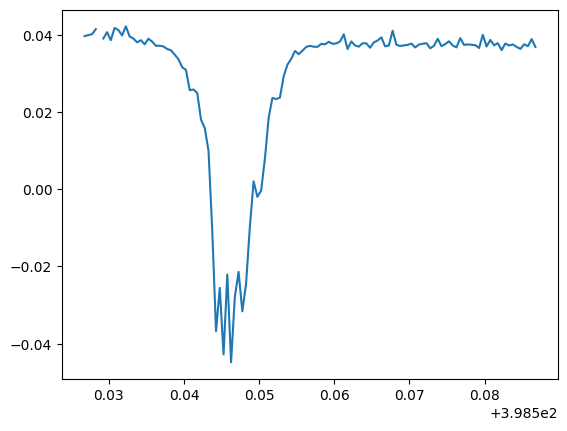

In [23]:
plt.plot(freq_actual*24, (on-off)/off)

Error in callback <function _draw_all_if_interactive at 0x000001BC0C767130> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

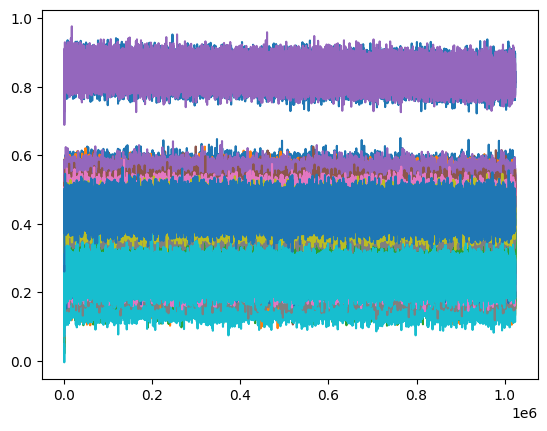

In [24]:
plt.plot(signal.T)

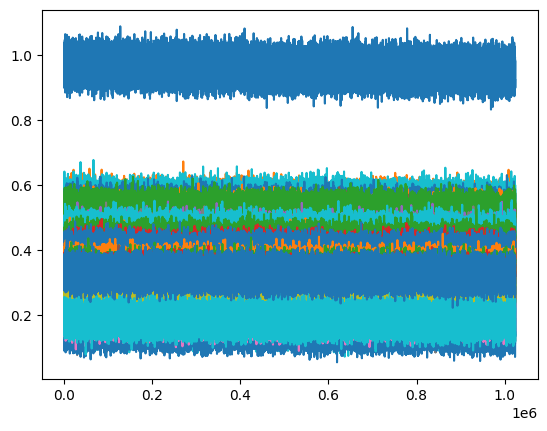

In [ ]:
plt.plot(background.T)